In [2]:
pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# 競馬予測AI分析ノートブック

## インポート
import sys
sys.path.append('../src')  # notebooksフォルダからの相対パス
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle
from horse_racing_analysis import HorseRacingAnalysis
from br_nr_calculator import calculate_br_nr


In [2]:
# レースデータの読み込み
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')

# 競馬場の緯度経度データの読み込み
place_latlon = pd.read_csv('../data/place_latlon.csv')

In [3]:
# データの読み込み
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')
place_latlon = pd.read_csv('../data/place_latlon.csv')

# 日付の変換
race_data['日付'] = pd.to_datetime(race_data['日付'], format='%Y年%m月%d日')


# 欠損値の処理
race_data.fillna(method='ffill', inplace=True)

# カテゴリ変数のエンコーディング
race_data['性'] = race_data['性'].astype('category').cat.codes
race_data['クラス'] = race_data['クラス'].astype('category').cat.codes
race_data['芝・ダート'] = race_data['芝・ダート'].astype('category').cat.codes
race_data['馬場'] = race_data['馬場'].astype('category').cat.codes
race_data['天気'] = race_data['天気'].astype('category').cat.codes

# 緯度経度データの結合
race_data = race_data.merge(place_latlon, left_on='場名', right_on='場名', how='left')

# 不要な列の削除
# race_data.drop(['場名'], axis=1, inplace=True)

/var/folders/g8/0gdhjbln7hz27y38gpbf92300000gn/T/ipykernel_8883/2988287847.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  race_data.fillna(method='ffill', inplace=True)


In [8]:
# データの読み込み
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')

# 列名の確認
print(race_data.columns)


Index(['race_id', '馬', '騎手ID', '騎手名', '騎手生年月日', '馬番', '走破時間', 'オッズ', '通過順',
       '着順', '体重', '体重変化', '性', '齢', '斤量', '上がり', '人気', 'レース名', '日付', '開催',
       'クラス', '芝・ダート', '距離', '回り', '馬場', '天気', '発走時刻', '場id', '場名'],
      dtype='object')


In [10]:
# データの読み込み
race_data = pd.read_csv('../data/place_latlon.csv')

# 列名の確認
print(race_data.columns)

Index(['競馬場名', '緯度', '経度', '場名'], dtype='object')


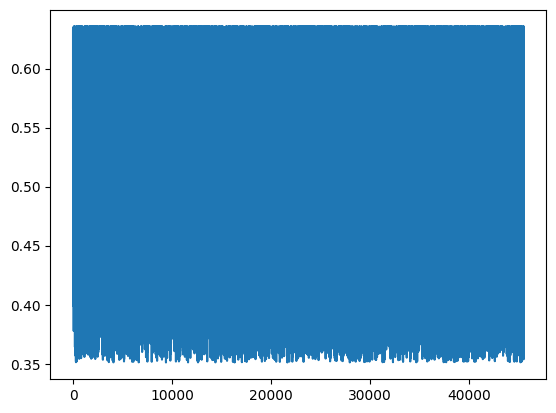

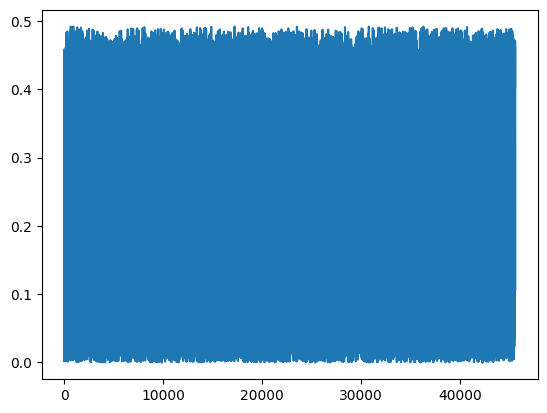

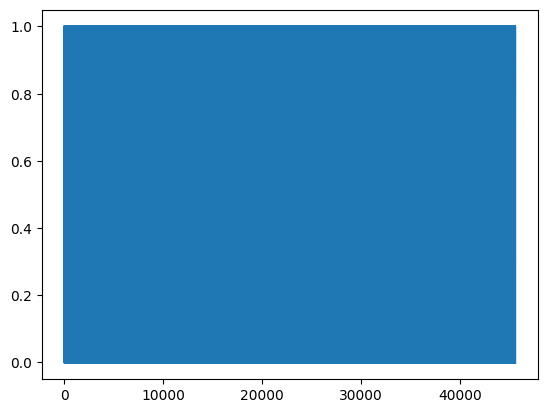

In [5]:
# 分析
# HorseRacingAnalysis クラスのインスタンス化
analysis = HorseRacingAnalysis()

# データからNR、Y、Z、Wの値を生成
analysis.generate_data(race_data, place_latlon)

# データの可視化
# Y軸のデータをプロット
analysis.plot_data(analysis.y_values)

# Z軸のデータをプロット
analysis.plot_data(analysis.z_values)

# W軸のデータをプロット
analysis.plot_data(analysis.w_values)

In [7]:
# 特徴量とターゲットの設定
X = pd.DataFrame({
    'NR': analysis.nr_values,
    'Y': analysis.y_values,
    'Z': analysis.z_values
})
y = analysis.w_values

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレストモデルの訓練
model = RandomForestClassifier()
model.fit(X_train, y_train)

# モデルの評価
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5705817782656422


In [9]:
# モデルの保存
# 訓練されたモデルをファイルに保存
with open('../models/trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

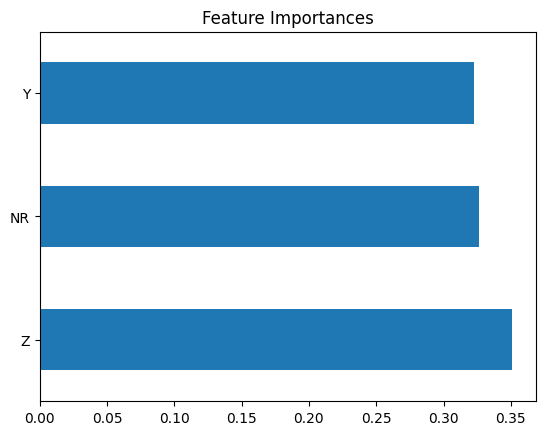

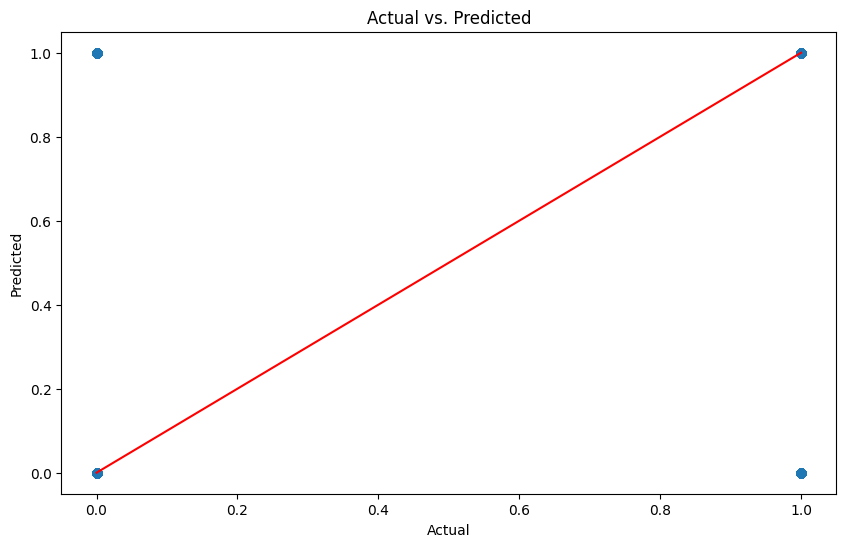

/var/folders/g8/0gdhjbln7hz27y38gpbf92300000gn/T/ipykernel_8883/3257084099.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


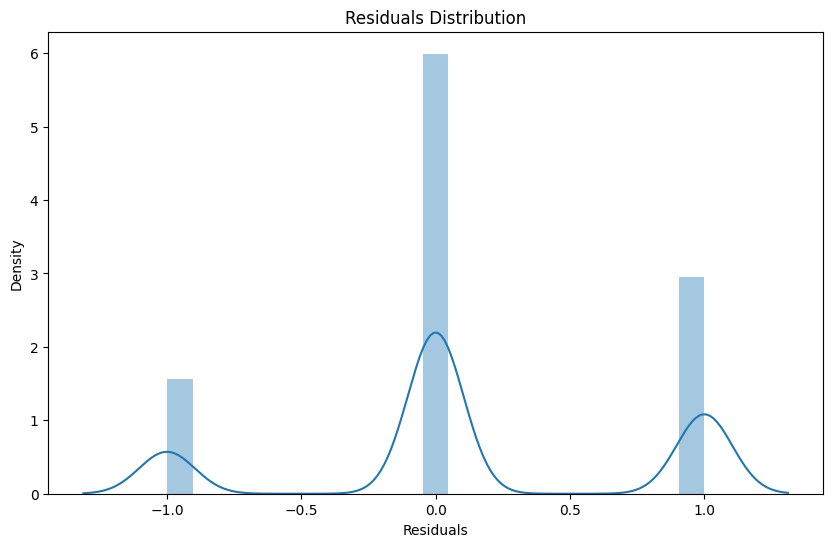

In [10]:
# 結果の可視化
# 特徴量の重要度を表示
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 実際の値と予測値を比較するプロット
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # 対角線
plt.show()

# 予測結果の分布を表示
plt.figure(figsize=(10, 6))
sns.distplot(y_test - y_pred)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

In [11]:
# フーリエ変換を使った場合

# データの読み込み
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')
place_latlon = pd.read_csv('../data/place_latlon.csv')

# 日付の変換
# '日付'カラムを datetime オブジェクトに変換
race_data['日付'] = pd.to_datetime(race_data['日付'], format='%Y年%m月%d日')

# 騎手の生年月日の変換
# '騎手生年月日'カラムを datetime オブジェクトに変換
race_data['騎手生年月日'] = pd.to_datetime(race_data['騎手生年月日'], format='%Y/%m/%d')

# 欠損値の処理
# 欠損値を前の値で埋める（前方補完）
race_data.fillna(method='ffill', inplace=True)

# カテゴリ変数のエンコーディング（必要に応じて）
# 例: '性'カラムを数値にエンコード
race_data['性'] = race_data['性'].map({'牡': 1, '牝': 2, 'セ': 3})

# その他の前処理
# 例: 不要なカラムの削除
# race_data.drop(['race_id', '馬', '騎手ID'], axis=1, inplace=True)


/var/folders/g8/0gdhjbln7hz27y38gpbf92300000gn/T/ipykernel_8883/1938961731.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  race_data.fillna(method='ffill', inplace=True)


In [13]:
# y_interpolated の内容を確認
print(y_interpolated)

0        0.566788
1        0.632767
2        0.535455
3        0.626215
4        0.564438
           ...   
91093    0.577164
91094    0.429927
91095    0.511534
91096    0.570857
91097    0.591625
Length: 91098, dtype: float64


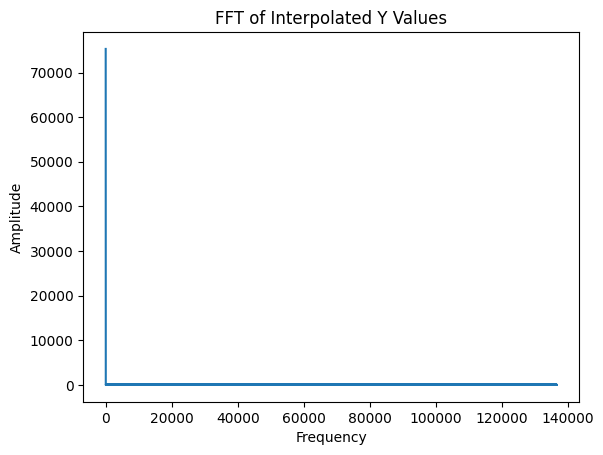

In [14]:
# NR、Y、Z、Wの値を生成
analysis.generate_data(race_data, place_latlon)

# Y軸データの補間
y_interpolated = analysis.interpolate_data(analysis.y_values)

# y_interpolated がリストやnumpy配列でない場合、変換する
if not isinstance(y_interpolated, (list, np.ndarray)):
    y_interpolated = list(y_interpolated)

# FFTの適用
fft_result = analysis.apply_fft(y_interpolated)

# FFT結果の可視化
plt.plot(np.abs(fft_result))
plt.title("FFT of Interpolated Y Values")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [62]:
###########  以下、FFT頑張ったけど全部数値じゃないとfit出来ないので諦めた  ###########

In [27]:
# 必要なライブラリのインポート
# 以下から(1)〜(6)も使った分析
import sys
sys.path.append('../src')  # notebooksフォルダからの相対パス
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
from astral import LocationInfo
from astral.sun import sun
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from horse_racing_analysis import HorseRacingAnalysis

# ここに(1)から(6)までの関数をインポートする
from elapsed_time_and_equatorial_conversion import calculate_elapsed_time_and_equatorial_coords
from coordinate_conversion import ecliptic_to_equatorial, equatorial_to_ecliptic
from sunrise_calculator import calculate_sunrise_elapsed_time_and_equatorial_coords
from sun_position_calculator import calculate_solar_ecliptic_coordinates
from age_calculator import calculate_age

In [61]:
# データの読み込み
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')
place_latlon = pd.read_csv('../data/place_latlon.csv')

# # 日付の変換
# race_data['日付'] = pd.to_datetime(race_data['日付'], format='%Y年%m月%d日')
# race_data['騎手生年月日'] = pd.to_datetime(race_data['騎手生年月日'])

# 日付と発走時刻の組み合わせて datetime オブジェクトを生成
# race_data['datetime'] = pd.to_datetime(race_data['日付'].str.replace('年', '-').str.replace('月', '-').str.replace('日', '') + ' ' + race_data['発走時刻'], format='%Y-%m-%d %H:%M')
race_data['datetime'] = race_data.apply(lambda row: datetime.strptime(f"{row['日付']} {row['発走時刻']}", '%Y年%m月%d日 %H:%M'), axis=1)

# タイムゾーンを設定
# race_data['datetime'] = race_data['datetime'].apply(lambda x: pytz.timezone('Asia/Tokyo').localize(x))

# # datetime をエポックタイムに変換
# race_data['datetime_epoch'] = race_data['datetime'].apply(lambda x: x.timestamp())

# 騎手生年月日を datetime オブジェクトに変換
race_data['騎手生年月日'] = pd.to_datetime(race_data['騎手生年月日'], format='%Y/%m/%d')

# 馬IDを生成
race_data['馬ID'] = race_data['馬'].astype(str)

# 騎手の能力と馬の能力の計算
race_data['騎手の能力'] = race_data.groupby('騎手ID')['着順'].transform('mean')
race_data['馬の能力'] = race_data.groupby('馬ID')['着順'].transform('mean')

# 新馬や新人騎手のデータ補完
for col in ['騎手の能力', '馬の能力']:
    race_data[col].fillna(race_data[col].min(), inplace=True)

# 不要な文字列型のカラムを削除
columns_to_drop = ['馬', '騎手ID', '騎手名', 'レース名', '開催', 'クラス', '芝・ダート', '回り', '馬場', '天気']
race_data.drop(columns_to_drop, axis=1, inplace=True)

# 目的変数の定義（1着かどうか）
race_data['is_winner'] = race_data['着順'].apply(lambda x: 1 if x == 1 else 0)

# 特徴量生成（HorseRacingAnalysisクラスを使用）
analysis = HorseRacingAnalysis()
analysis.generate_data(race_data, place_latlon)

# # 日付データの変換
# race_data['騎手生年月日'] = pd.to_datetime(race_data['騎手生年月日'], format='%Y/%m/%d')

# # 日付データをエポックタイムに変換
# race_data['騎手生年月日_epoch'] = (race_data['騎手生年月日'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

# (1)〜(6)の関数を使用したFFT特徴量生成
features = []
for index, row in race_data.iterrows():
    # 緯度と経度の取得（浮動小数点数に変換）
    latitude = float(place_latlon[place_latlon['場名'] == row['場名']]['緯度'].iloc[0])
    longitude = float(place_latlon[place_latlon['場名'] == row['場名']]['経度'].iloc[0])

    # 日付と時間の組み合わせ
    # race_date_str = row['日付']  # 'YYYY年MM月DD日' 形式の文字列
    # race_time_str = row['発走時刻']
    # race_datetime_str = f"{race_date_str} {race_time_str}"
    # race_datetime = datetime.strptime(race_datetime_str, '%Y年%m月%d日 %H:%M')
    # race_datetime = pytz.timezone('Asia/Tokyo').localize(race_datetime)

    # 日時の取得
    race_datetime = row['datetime']

    # 日の出時刻と日の出からの経過時間を計算
    try:
        elapsed_time, sunrise_time = calculate_elapsed_time_and_equatorial_coords(race_datetime, latitude, longitude)
        # print(f"Elapsed time: {elapsed_time} minutes, Equatorial coordinates: {sunrise_time}")
    except Exception as e:
        print(f"Error calculating elapsed time and equatorial coordinates for row {index}: {e}, latitude={latitude}, longitude={longitude}, race_datetime={race_datetime}")

    # 太陽の黄道座標を計算
    ecliptic_coords = calculate_solar_ecliptic_coordinates(race_datetime, sunrise_time, elapsed_time)

    # 騎手の年齢を計算
    row['日付'] = pd.to_datetime(row['日付'], format='%Y年%m月%d日')
    age_days, age_years = calculate_age(row['騎手生年月日'], row['日付'])

    # ephem.Angle オブジェクトを浮動小数点数（度）に変換
    ecliptic_coord_0_deg = float(ecliptic_coords[0])
    ecliptic_coord_1_deg = float(ecliptic_coords[1])
    print('ecliptic_coord_0_deg=', ecliptic_coord_0_deg)
    print('ecliptic_coord_1_deg=', ecliptic_coord_1_deg)

    # FFTを適用して特徴量を生成
    fft_result = fft([elapsed_time, ecliptic_coord_0_deg, ecliptic_coord_1_deg, age_days, age_years])
    print('fftまでできてる')
    fft_features = np.abs(fft_result)
    print('fftのabsまでできてる')

    features.append(fft_features)
    print('fftのappendまでできてる')

# 特徴量データフレームの作成
features_df = pd.DataFrame(features)
print('features_df作成までできてる')

# FFT特徴量をデータフレームに追加
for i in range(features_df.shape[1]):
    race_data[f'fft_feature_{i}'] = features_df[i]
    print('features_df作成の次までできてる')

# 新馬や新人騎手のデータ補完
for col in ['騎手の能力', '馬の能力']:
    race_data[col].fillna(race_data[col].min(), inplace=True)
    print('騎手と馬の能力作れてる')

# 日付や時刻データをエポックタイムに変換
race_data['datetime_epoch'] = race_data['datetime'].apply(lambda x: x.timestamp())
race_data['騎手生年月日_epoch'] = race_data['騎手生年月日'].apply(lambda x: x.timestamp())

# データの前処理と分割
X = race_data.drop(['is_winner', 'datetime', '騎手生年月日', '走破時間', 'オッズ', '通過順', '性', '日付', '発走時刻', '場名', '馬ID'], axis=1)
y = race_data['is_winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X, y = ', X, y)

# モデルの訓練と予測
model = RandomForestClassifier()
print('モデル作れてる')
model.fit(X_train, y_train)
print('モデルfitできた')
y_pred = model.predict(X_test)
print('モデルpredictできた')

# 結果の可視化と評価
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
sns.distplot(y_test - y_pred)
plt.title("Prediction Error")
plt.show()


ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる
ecliptic_coord_0_deg= 2.081550538691515
ecliptic_coord_1_deg= -4.14878213500171e-05
fftまでできてる
fftのabsまでできてる
fftのappendまでできてる


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [59]:
# 数値に変換できない値を含む行を特定
for column in race_data.columns:
    # 数値に変換できない値を含む行を特定
    invalid_rows = race_data[race_data[column].apply(lambda x: isinstance(x, str) and not x.replace('.', '', 1).isdigit())]
    if not invalid_rows.empty:
        print(f"Column '{column}' contains non-numeric values in the following rows:")
        print(invalid_rows)

Column '走破時間' contains non-numeric values in the following rows:
            race_id     騎手生年月日  馬番    走破時間    オッズ          通過順  着順   体重  体重変化  \
0      202301010101 1998-12-22   5  1:09.5    1.2          2-2   1  452    -4   
1      202301010101 1988-12-25   8  1:09.5    4.1          1-1   2  454     2   
2      202301010101 1986-03-17   6  1:10.0   59.9          5-4   3  438    -6   
3      202301010101 1979-05-20   4  1:10.2   16.6          3-3   4  450     2   
4      202301010101 1983-12-20   1  1:10.3   23.9          8-8   5  434   -10   
...             ...        ...  ..     ...    ...          ...  ..  ...   ...   
45544  202310030812 1979-04-22   1  2:42.9   62.8    11-11-8-7   8  394     2   
45545  202310030812 2003-09-18   7  2:43.5  125.6    5-5-10-11   9  470    -4   
45546  202310030812 1977-06-23   2  2:43.6    9.8      3-3-4-5  10  496     8   
45547  202310030812 2004-03-09   4  2:43.7   37.2      2-2-4-7  11  440    -2   
45548  202310030812 2003-05-21   5  2:44.1  

In [23]:
place_latlon

競馬場名       緯度        経度  場名
0  東京競馬場  35.6723  139.7447  東京
1  中山競馬場  35.5919  139.9836  中山
2  京都競馬場  34.9811  135.7594  京都
3  阪神競馬場  34.7263  135.3618  阪神
4  中京競馬場  35.1814  136.9366  中京
5  札幌競馬場  43.0152  141.4133  札幌
6  函館競馬場  41.7737  140.7033  函館
7  福島競馬場  37.7608  140.4747  福島
8  新潟競馬場  37.9161  139.0364  新潟
9  小倉競馬場  33.8709  130.8202  小倉

In [63]:
########### 以下から、(1)~(6)を使ったランダムフォレスト ###########
# Accuracy: 0.9998902305159165

In [42]:
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')
place_latlon = pd.read_csv('../data/place_latlon.csv')
pd.set_option('display.max_columns', None)
race_data.head()

race_id          馬  騎手ID     騎手名      騎手生年月日  馬番    走破時間   オッズ  通過順  \
0  202301010101    サトミノキラリ  1170    横山武史  1998/12/22   5  1:09.5   1.2  2-2   
1  202301010101     ベアゴーゴー  1115     浜中俊  1988/12/25   8  1:09.5   4.1  1-1   
2  202301010101  ハピアーザンエバー  1093    藤岡佑介  1986/03/17   6  1:10.0  59.9  5-4   
3  202301010101  デビルシズカチャン  5339  Ｃ．ルメール  1979/05/20   4  1:10.2  16.6  3-3   
4  202301010101   ウィスピースノー  1095    吉田隼人  1983/12/20   1  1:10.3  23.9  8-8   

   着順   体重  体重変化  性  齢    斤量   上がり   人気   レース名          日付       開催    クラス  \
0   1  452    -4  牡  2  55.0  34.3  8.0  2歳未勝利  2023年7月22日  1回札幌1日目  2歳未勝利   
1   2  454     2  牝  2  55.0  34.5  6.0  2歳未勝利  2023年7月22日  1回札幌1日目  2歳未勝利   
2   3  438    -6  牡  2  55.0  34.5  4.0  2歳未勝利  2023年7月22日  1回札幌1日目  2歳未勝利   
3   4  450     2  牝  2  55.0  34.9  1.0  2歳未勝利  2023年7月22日  1回札幌1日目  2歳未勝利   
4   5  434   -10  牝  2  55.0  34.5  2.0  2歳未勝利  2023年7月22日  1回札幌1日目  2歳未勝利   

  芝・ダート    距離 回り 馬場 天気   発走時刻  場id  場名  
0     芝  1200  右  良  晴  09:50    1  札幌  
1     芝  1200  右  良  晴  09:50    1  札幌  
2     芝  1200  右  良  晴  09:50    1  札幌  
3     芝  1200  右  良  晴  09:50    1  札幌  
4     芝  1200  右  良  晴  09:50    1  札幌

In [3]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pytz
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# notebooksフォルダからの相対パス
import sys
sys.path.append('../src')

# ここに(1)から(6)までの関数をインポートする
from elapsed_time_and_equatorial_conversion import calculate_elapsed_time_and_equatorial_coords
from coordinate_conversion import ecliptic_to_equatorial, equatorial_to_ecliptic
from sunrise_calculator import calculate_sunrise_elapsed_time_and_equatorial_coords
from sun_position_calculator import calculate_solar_ecliptic_coordinates
from age_calculator import calculate_age

def convert_time_to_seconds(time_str):
    """走破時間を秒数に変換する関数"""
    if ':' in time_str:
        minutes, seconds = time_str.split(':')
        return float(minutes) * 60 + float(seconds)
    else:
        return float(time_str)

def extract_final_position(position_str):
    """最終通過順を抽出する関数"""
    return int(position_str.split('-')[-1])

def calculate_average_position(position_str):
    """平均通過順を計算する関数"""
    positions = [int(pos) for pos in position_str.split('-')]
    return sum(positions) / len(positions)

# データの読み込み
race_data = pd.read_csv('../data/2023-12-13_keiba_racedata_2023.csv')
place_latlon = pd.read_csv('../data/place_latlon.csv')

# データフレーム内の '---' を NaN に置き換える
race_data.replace('---', np.nan, inplace=True)

# 欠損値の処理
race_data.fillna(method='ffill', inplace=True)

# ワンホットエンコーディングの適用
race_data = pd.get_dummies(race_data, columns=['レース名'])

# ワンホットエンコーディング後のデータフレームは、元のレース名カラムを削除し、
# 各レース名に対応する新しい列が追加された状態になります。

# ラベルエンコーダーの初期化
label_encoder = LabelEncoder()

# 開催カラム（例えば '開催'）をラベルエンコーディング
race_data['開催'] = label_encoder.fit_transform(race_data['開催'])
# '回り' カラム（例えば '回り'）をラベルエンコーディング
race_data['回り'] = label_encoder.fit_transform(race_data['回り'])

# データフレームに適用する
race_data['走破時間'] = race_data['走破時間'].apply(convert_time_to_seconds)
# 最終通過順を使用する場合
race_data['通過順'] = race_data['通過順'].apply(extract_final_position)

# カテゴリ変数のエンコーディング
category_columns = ['性', 'クラス', '芝・ダート', '馬場', '天気', '騎手名', '馬']
for col in category_columns:
    race_data[col] = race_data[col].astype('category').cat.codes

# 緯度経度データの結合
race_data = race_data.merge(place_latlon, on='場名', how='left')

# 騎手生年月日を datetime オブジェクトに変換し、タイムゾーンを設定
race_data['騎手生年月日'] = pd.to_datetime(race_data['騎手生年月日'], format='%Y/%m/%d')
race_data['騎手生年月日'] = race_data['騎手生年月日'].dt.tz_localize('Asia/Tokyo')

# 日付と発走時刻の組み合わせて datetime オブジェクトを生成
race_data['datetime'] = pd.to_datetime(race_data['日付'] + ' ' + race_data['発走時刻'], format='%Y年%m月%d日 %H:%M').dt.tz_localize('Asia/Tokyo')

# 特徴量生成
def generate_features(row):
    latitude = float(place_latlon[place_latlon['場名'] == row['場名']]['緯度'].iloc[0])
    longitude = float(place_latlon[place_latlon['場名'] == row['場名']]['経度'].iloc[0])
    elapsed_time, _ = calculate_elapsed_time_and_equatorial_coords(row['datetime'], latitude, longitude)
    ecliptic_coords = calculate_solar_ecliptic_coordinates(row['datetime'], latitude, longitude)
    age_days, age_years = calculate_age(row['騎手生年月日'], row['datetime'])
    return pd.Series([elapsed_time, ecliptic_coords[0], ecliptic_coords[1], age_days, age_years])

race_data[['elapsed_time', 'ecliptic_lon', 'ecliptic_lat', 'age_days', 'age_years']] = race_data.apply(generate_features, axis=1)

# 'is_winner' カラムの生成
race_data['is_winner'] = race_data['着順'].apply(lambda x: 1 if x == 1 else 0)

# カラムをラベルエンコーディング
race_data['場名'] = label_encoder.fit_transform(race_data['場名'])
race_data['競馬場名'] = label_encoder.fit_transform(race_data['競馬場名'])

# データの前処理と分割
features_to_drop = ['日付', '発走時刻', '騎手生年月日', 'datetime', '着順', '場名', '競馬場名']
X = race_data.drop(features_to_drop, axis=1)
y = race_data['is_winner']

# 特徴量とターゲットの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルの訓練と予測
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 結果の評価
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


/var/folders/g8/0gdhjbln7hz27y38gpbf92300000gn/T/ipykernel_2488/951068416.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  race_data.fillna(method='ffill', inplace=True)


Accuracy: 0.9998902305159165


# まずは一着の精度を上げる（特徴量を見極めたい）
（後でどれが有効か評価できるように、パラメータをON/OFFできるようにする）
* 騎手と馬とで重み付けを分ける
    重み付けは項目ごとで付けられるのか？
    ランダムフォレストは適切なのか
* 人気馬がコケた場合
    人気馬がコケる確率を出せると的中率上がる
* オッズのロジック？
    馬主の人気度もある
* 人気のある馬とは
    前走で成績が良い
    ただし期間が空いてると人気にはならなそう
    前走の成績の良い馬は前走の結果理由を調べたい
* 前走と前前走の成績が上向きかどうかを考慮する
    直前2レース
    可視化する
    着順が良かったら成績が良いとなるのか？ => レースごとの全馬の数も違うので微妙
    「成績の上向き」の基準は？
        前走がその日の平均値より上だったら
        前のコースと同じ状況か
        天気が大荒れの場合は参考にはならない
        前走の結果がある程度調子が良くて且つ着順が良ければ参考にして良さそう
        着順の出し方：パーセンテージで出したほうが良さそう？：全馬の数によって評価が変わってくる
        前走が1着とのタイム差が少なければ調子が良さそう（採用）　100メートルあたりの平均タイム差が小さければ良い
* 馬体重が増えてるのは微妙。減ってたほうが良い。（体重の変化）：馬の調子
* 馬の生年月日（体内時計）と前走の成績の相関を出せたら凄そう => 塩野さん考えてくれる
* アプリ画面について
    グラフで前走と前前走の成績をグラフで見せると良さそう
    直近3レースにするのか？とかパラメータを変えられるようにしておくとよし

まずはソース送る

実際に適合したデータか？
本当にランダムフォレストが良いのか？
パラメータの調整？
重み付けはさっきのやつ
１着からのタイム順のデータとか項目入れて考える
全部のコードを見せる
1〜6が正確か見る => 塩野さん
他のモデルで質問してみる
なんでランダムフォレストか聞いてみる
特徴量をAIに聞く
タイム差での調子判断についてAIに聞く


In [44]:
print(place_latlon)

    競馬場名       緯度        経度  場名
0  東京競馬場  35.6723  139.7447  東京
1  中山競馬場  35.5919  139.9836  中山
2  京都競馬場  34.9811  135.7594  京都
3  阪神競馬場  34.7263  135.3618  阪神
4  中京競馬場  35.1814  136.9366  中京
5  札幌競馬場  43.0152  141.4133  札幌
6  函館競馬場  41.7737  140.7033  函館
7  福島競馬場  37.7608  140.4747  福島
8  新潟競馬場  37.9161  139.0364  新潟
9  小倉競馬場  33.8709  130.8202  小倉


In [45]:
##### ここから、AIの考えた特徴量も組み込み #####

0          札幌
1          札幌
2          札幌
3          札幌
4          札幌
         ... 
652936    NaN
652937    NaN
652938    NaN
652939    NaN
652940    NaN
Name: 場名, Length: 652941, dtype: object


In [4]:
# モデルの保存
import pickle
# 訓練されたモデルをファイルに保存
with open('../models/trained_model_v2.pkl', 'wb') as file:
    pickle.dump(model, file)

In [40]:
pd.set_option('display.max_columns', None)
race_data.head()

race_id     馬  騎手ID  騎手名                    騎手生年月日  馬番  走破時間   オッズ  \
0  202301010101  3534  1170  100 1998-12-22 00:00:00+09:00   5  69.5   1.2   
1  202301010101  8329  1115  115 1988-12-25 00:00:00+09:00   8  69.5   4.1   
2  202301010101  6971  1093  145 1986-03-17 00:00:00+09:00   6  70.0  59.9   
3  202301010101  6036  5339  174 1979-05-20 00:00:00+09:00   4  70.2  16.6   
4  202301010101   893  1095   29 1983-12-20 00:00:00+09:00   1  70.3  23.9   

   通過順  着順   体重  体重変化  性  齢    斤量   上がり   人気          日付  開催  クラス  芝・ダート  \
0    2   1  452    -4  2  2  55.0  34.3  8.0  2023年7月22日  54    3      1   
1    1   2  454     2  1  2  55.0  34.5  6.0  2023年7月22日  54    3      1   
2    4   3  438    -6  2  2  55.0  34.5  4.0  2023年7月22日  54    3      1   
3    3   4  450     2  1  2  55.0  34.9  1.0  2023年7月22日  54    3      1   
4    8   5  434   -10  1  2  55.0  34.5  2.0  2023年7月22日  54    3      1   

     距離  回り  馬場  天気   発走時刻  場id  場名  レース名_2歳1勝クラス  レース名_2歳新馬  レース名_2歳未勝利  \
0  1200   0   2   1  09:50    1   6         False      False        True   
1  1200   0   2   1  09:50    1   6         False      False        True   
2  1200   0   2   1  09:50    1   6         False      False        True   
3  1200   0   2   1  09:50    1   6         False      False        True   
4  1200   0   2   1  09:50    1   6         False      False        True   

   レース名_3歳1勝クラス  レース名_3歳以上1勝クラス  レース名_3歳以上2勝クラス  レース名_3歳新馬  レース名_3歳未勝利  \
0         False           False           False      False       False   
1         False           False           False      False       False   
2         False           False           False      False       False   
3         False           False           False      False       False   
4         False           False           False      False       False   

   レース名_4歳以上1勝クラス  レース名_4歳以上2勝クラス  レース名_BSN賞(L)  レース名_BSイレブン賞   レース名_HBC賞   \
0           False           False         False          False       False   
1           False           False         False          False       False   
2           False           False         False          False       False   
3           False           False         False          False       False   
4           False           False         False          False       False   

   レース名_HTB杯   レース名_HTB賞   レース名_JRAアニバーサリー   レース名_JRAアプリ記念   レース名_Mシンボリクリスエス   \
0       False       False             False           False             False   
1       False       False             False           False             False   
2       False       False             False           False             False   
3       False       False             False           False             False   
4       False       False             False           False             False   

   レース名_Mロードカナロア   レース名_NST賞   レース名_RKB賞   レース名_STV杯   レース名_STV賞   レース名_TUF杯   \
0           False       False       False       False       False       False   
1           False       False       False       False       False       False   
2           False       False       False       False       False       False   
3           False       False       False       False       False       False   
4           False       False       False       False       False       False   

   レース名_TVh杯   レース名_TVh賞   レース名_UHB杯   レース名_UHB賞   レース名_tvk賞   レース名_あざみ賞   \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   
3       False       False       False       False       False       False   
4       False       False       False       False       False       False   

   レース名_あすなろ賞   レース名_あずさ賞   レース名_あやめ賞   レース名_いわき特別   レース名_おおぞら特別   \
0        False       False       False        False         False   
1        False       False       False        False         False   
2        False       False       False        False         False  